In [1]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import utils as utl
import html_evaluation_portfolio as hep
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img

## Title

In [100]:
def create_dataframe_high_low(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_low'] = hist['Low']
        df[security + '_high'] = hist['High']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_park_volatility(df_high_low, list_securities, window):
    '''
    input
    df = pandas dataframe with columns named: "security_low" and "security_high" (e.g. SSO_low SSO_high)
    list_securities = list of securities name
    window = int, number of days the index has to consider

    output
    df_output = pandas dataframe with securities as columns and parkinson volat estimator as rows

    '''


    k = np.sqrt(1/(4*window*np.log(2)))
    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_high_low) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_high_low[security + '_high'][i+j] / df_high_low[security + '_low'][i+j])**2))
                # len(array_day_value) = window
            square_sum_value = np.sqrt(np.sum(array_day_value))
            array_value = np.append(array_value, k*square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,

def index_df(df_output, data):
    #just add the index to the dataframe
    data_copy = data.copy()
    data_copy.drop(data_copy.tail(window).index, inplace=True) # drop last n rows

    return df_output.set_index(data_copy.index)

def dataframe_strd_dev(data, window):
    df_output = pd.DataFrame()

    list_securities = data.columns
    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(data) - window): 
            array_value = np.append(array_value, np.std(data[security][i:i+window]))
            
        # assign new array as column of the df
        df_output[security] = array_value
        
    return df_output

def create_dataframe_ohlc(list_securities):
    df = pd.DataFrame()
    for security in list_securities:
        SEC = yf.Ticker(security)
        hist = SEC.history(period="max")
        df[security + '_open'] = hist['Open']
        df[security + '_high'] = hist['High']
        df[security + '_low'] = hist['Low']
        df[security + '_close'] = hist['Close']
        df.dropna(inplace = True) #if this line the data are only from 2010 otyherwise some columns arrive until 2006
    return df

def compute_satchell_volatility(df_ohlc, list_securities, window):

    df_output = pd.DataFrame()

    for security in list_securities:
        #crating array to store the indexes (one per day)
        array_value = np.array([])
        for i in range(len(df_ohlc) - window):
            
            #creating array where storing the log((High_price/Low_price)^2)
            array_day_value = np.array([])
            for j in range(window):
                #array_day_value = np.array([])

                #appending the value (one for each window day)
                array_day_value = np.append(array_day_value, np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_high'][i+j] / df_ohlc[security + '_open'][i+j]))
                                                            + np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_close'][i+j]))*np.log((df_ohlc[security + '_low'][i+j] / df_ohlc[security + '_open'][i+j])))
                # len(array_day_value) = window
            square_sum_value = np.sqrt((1/window)*np.sum(array_day_value))
            array_value = np.append(array_value,square_sum_value)

        #dict_security_park_indx[security] = array_value
        df_output[security] = array_value
    return df_output #dict_security_park_indx,


In [2]:
list_securities = ['SSO', 'UBT', 'UST', 'UPW', 'UGL']
window = 30 #days

In [92]:
data_h_l = create_dataframe_high_low(list_securities)
data_h_l = data_h_l[-1834:]
df_park_volat = compute_park_volatility(data_h_l, list_securities, window)
data = hep.create_dataframe(list_securities)
data = data[-1834:]
#data.dropna(inplace = True)
df_park_volat = index_df(df_park_volat, data)

In [81]:
df_strd_dev =  dataframe_strd_dev(data, 30)
df_strd_dev = index_df(df_strd_dev, data)

In [101]:
data_ohlc = create_dataframe_ohlc(list_securities)
data_ohlc = data_ohlc[-1834:]
df_satchell_volat = compute_satchell_volatility(data_ohlc, list_securities, window)

df_satchell_volat = index_df(df_satchell_volat, data)
df_satchell_volat

,SSO,UBT,UST,UPW,UGL
Date,,,,,
2014-12-29,0.016356,0.013558,0.005009,0.019514,0.013835
2014-12-30,0.016456,0.013678,0.005057,0.019276,0.013760
2014-12-31,0.016464,0.013830,0.005108,0.019143,0.013311
2015-01-02,0.016399,0.013812,0.005093,0.019231,0.013306
2015-01-05,0.016102,0.013855,0.005224,0.019349,0.012977
...,...,...,...,...,...
2022-02-18,0.020282,0.015617,0.005566,0.009490,0.017329
2022-02-22,0.020013,0.015849,0.005596,0.010520,0.017347
2022-02-23,0.019596,0.015932,0.005575,0.011330,0.017457


In [103]:
df_volat_SSO = pd.DataFrame()
df_volat_SSO['Stv'] = df_strd_dev['SSO']
df_volat_SSO['Park'] = df_park_volat['SSO']
df_volat_SSO['Satch'] = df_satchell_volat['SSO']

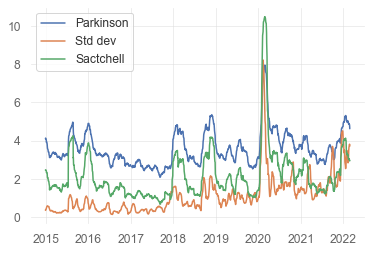

In [113]:
plt.plot(df_volat_SSO['Park']*30, label = 'Parkinson')
plt.plot(df_volat_SSO['Stv'], label = 'Std dev')
plt.plot(df_volat_SSO['Satch']*150, label = 'Sactchell')

plt.legend()
plt.show()

            Stv      Park     Satch
Stv    1.000000  0.689900  0.732923
Park   0.689900  1.000000  0.951848
Satch  0.732923  0.951848  1.000000


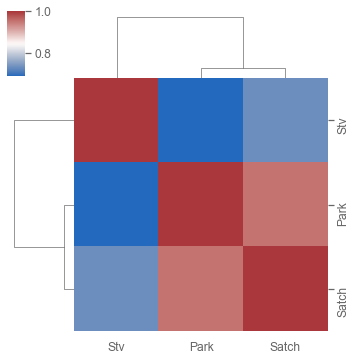

In [114]:
corr = df_volat_SSO.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')